In [1]:
import numpy as np

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Concatenate, Dense, Conv2D, LeakyReLU, Conv2DTranspose, Flatten, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import tensorflow_datasets as tfds

In [12]:
def build_generator(img_size, latent_dim):
    z = Input(latent_dim)
    x = tf.keras.layers.Reshape((2, 2, 32))(z)
    x = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding="same", activation = tf.nn.leaky_relu)(x)
    x = Conv2D(512, (3, 3), padding="same", activation = tf.nn.leaky_relu)(x)
    x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding="same", activation = tf.nn.leaky_relu)(x)
    x = Conv2D(256, (3, 3), padding="same", activation = tf.nn.leaky_relu)(x)
    x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding="same", activation = tf.nn.leaky_relu)(x)
    x = Conv2D(128, (3, 3), padding="same", activation = tf.nn.leaky_relu)(x)
    x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding="same", activation = tf.nn.leaky_relu)(x)
    x = Conv2D(128, (3, 3), padding="same", activation = tf.nn.leaky_relu)(x)
    x = Conv2DTranspose(img_size[-1], (3,3),strides=(2,2),padding="same", activation = tf.nn.leaky_relu)(x)
    return Model(z, x)

def build_encoder(img_size, latent_dim):
    x = Input(img_size)
    y = Conv2D(128, (3, 3), strides=(2, 2), padding="same", activation = tf.nn.leaky_relu)(x)
    y = Conv2D(128, (3, 3), padding="same", activation = tf.nn.leaky_relu)(y)
    y = Conv2D(256, (3, 3), strides=(2, 2), padding="same", activation = tf.nn.leaky_relu)(y)
    y = Conv2D(256, (3, 3), padding="same", activation = tf.nn.leaky_relu)(y)
    y = Conv2D(512, (3, 3), strides=(2, 2), padding="same", activation = tf.nn.leaky_relu)(y)
    y = Conv2D(512, (3, 3), padding="same", activation = tf.nn.leaky_relu)(y)
    y = Conv2D(512, (3, 3), strides=(2, 2), padding="same", activation = tf.nn.leaky_relu)(y)
    y = Conv2D(512, (3, 3), padding="same", activation = tf.nn.leaky_relu)(y)
    y = Flatten()(y)
    y = Dense(256, activation = tf.nn.leaky_relu)(y)
    y = Dense(latent_dim)(y)
    return Model(x,y)

def build_discriminator(img_size, latent_dim):
    x = Input(img_size)
    z = Input(latent_dim)
    _z = Flatten()(z)
    _z = Dense(img_size[0]*img_size[1]*img_size[2])(_z)
    _z = Reshape(img_size)(_z)

    y = Concatenate()([x,_z])
    y = Conv2D(128, (3, 3), strides=(2, 2), padding="same", activation = tf.nn.leaky_relu)(y)
    y = Conv2D(128, (3, 3), padding="same", activation = tf.nn.leaky_relu)(y)
    y = Conv2D(256, (3, 3), strides=(2, 2), padding="same", activation = tf.nn.leaky_relu)(y)
    y = Conv2D(256, (3, 3), padding="same", activation = tf.nn.leaky_relu)(y)
    y = Conv2D(512, (3, 3), strides=(2, 2), padding="same", activation = tf.nn.leaky_relu)(y)
    y = Conv2D(512, (3, 3), padding="same", activation = tf.nn.leaky_relu)(y)
    y = Conv2D(1024, (3, 3), strides=(2, 2), padding="same", activation = tf.nn.leaky_relu)(y)
    y = Conv2D(1024, (3, 3), padding="same", activation = tf.nn.leaky_relu)(y)
    y = Flatten()(y)
    y = Dense(1)(y)
    return Model([x, z], [y])



In [31]:
def load_dataset(data_dir, img_size = 64, batch_size = 1):
    df = tf.keras.utils.image_dataset_from_directory(directory = data_dir, 
                                                     labels = None, 
                                                     batch_size= None,
                                                     image_size = (img_size, img_size),
                                                     seed = 42)
    
    return df

In [46]:
data_folder = "sample_data/"
img_dim = 64
train_ds = load_dataset(data_folder+"img", img_size = img_dim, batch_size = 1)

Found 2560 files belonging to 1 classes.


In [47]:
def apply_norm(x):
    return (x*2)/255.0 - 1

In [48]:
latent_dim = 128
img_size = (img_dim, img_dim, 3)

enc = build_encoder(img_size, latent_dim)
gen = build_generator(img_size, latent_dim)
disc = build_discriminator(img_size, latent_dim)

g_opt = Adam(learning_rate = 1e-4)
e_opt = Adam(learning_rate = 1e-4)
d_opt = Adam(learning_rate = 1e-4)


In [49]:
num = len(train_ds)

train_ds = train_ds.map(apply_norm)
train_ds = tfds.as_numpy(train_ds)

In [50]:
z_train = np.random.normal(size = (num, latent_dim)).astype("float32")

In [51]:
import random

t = list(zip(train_ds, z_train))
random.shuffle(t)
train_ds, z_train = zip(*t)

train_ds = np.array(train_ds)
z_train = np.array(z_train)

In [52]:
epochs = 1
batch_size = 1

In [53]:
z_train.shape

(2560, 128)

In [54]:
X_train = train_ds.reshape(-1, batch_size, img_dim, img_dim, 3)
z_train = z_train.reshape(-1, batch_size, latent_dim)

In [55]:
for epoch in tqdm(range(epochs), desc='Total'):
    
    running_loss = [0,0,0]
    num_steps = num//batch_size
    
    perm = np.random.permutation(X_train.shape[0])
    
    X_train = X_train[perm]
    z_train = np.random.normal(size = (num,latent_dim)).astype("float32")
    z_train = z_train.reshape(-1, batch_size, latent_dim)
    
    for steps in range(0, num_steps):
        x_batch = X_train[steps]
        z_batch = z_train[steps]
        
        with tf.GradientTape(persistent=True, watch_accessed_variables=True) as tape:      
            fake_img = gen(z_batch)
            fake_z = enc(x_batch)

            preds = disc([tf.concat([fake_img, x_batch], axis = 0) , tf.concat([z_batch, fake_z], axis = 0)])
            pred_gen, pred_enc = tf.split(preds, 2, axis = 0)
            
            gen_loss = tf.reduce_mean(tf.nn.softplus(-pred_gen))
            enc_loss = tf.reduce_mean(tf.nn.softplus(pred_enc))
            
            disc_loss = tf.reduce_mean(tf.nn.softplus(pred_gen)) + tf.reduce_mean(tf.nn.softplus(-pred_enc))

        gen_grad = tape.gradient(gen_loss, gen.trainable_variables)        
        disc_grad = tape.gradient(disc_loss, disc.trainable_variables)
        enc_grad = tape.gradient(enc_loss, enc.trainable_variables)

        g_opt.apply_gradients(zip(gen_grad,gen.trainable_variables))
        e_opt.apply_gradients(zip(enc_grad,enc.trainable_variables))
        d_opt.apply_gradients(zip(disc_grad,disc.trainable_variables))

        running_loss[0] += disc_loss.numpy()
        running_loss[1] += gen_loss.numpy()
        running_loss[2] += enc_loss.numpy()
        del tape
    print('[{}] Desc loss : {:.10f}\t Gen Loss : {:.10f}\t Enc Loss : {:.10f}'.format(epoch,running_loss[0],running_loss[1], running_loss[2] ))

Total:   0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

1/1 [==============================] - 0s 43ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

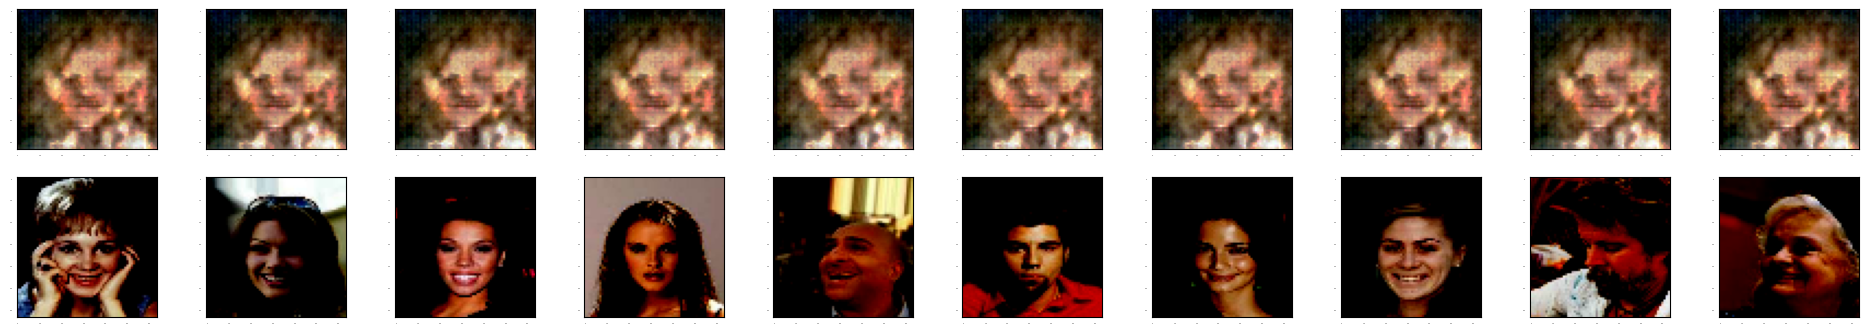

In [16]:
for _ in range(1):
    num_sample = 10
    z_test = np.random.normal(size = (num, latent_dim)).astype("float32")
    pred = gen.predict(z_test[:num_sample]).reshape(-1, img_dim, img_dim, 3)

    _, axs = plt.subplots(2,num_sample, figsize=(24,4))
    for i in range(num_sample):
        img = np.clip((pred[i]+1)*(255.0/2), 0, 255).astype("uint32")
        axs[0][i].imshow(img)
        axs[0][i].tick_params(length=0, labelsize=0)
        
        axs[1][i].imshow(X_train[0][i])
        axs[1][i].tick_params(length=0, labelsize=0)